# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 9th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 3 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "peter"
ln1 = "martigny"
fn2 = "benoît"
ln2 = "choffin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_martigny_peter_and_choffin_benoît.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn


#np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

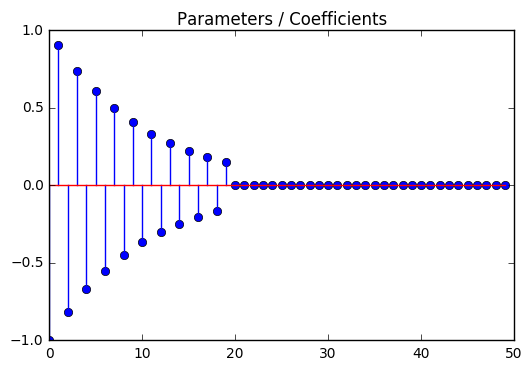

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [6]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""   
    aux = np.abs(x)
    result = np.sign(x) * np.maximum((aux - s*t), 0)
    return result
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    aux = np.abs(x)
    result = s * np.sum(aux)
    return result

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    result = (1/(1 + s*t)) * x
    return result
    
def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    result = (s/2) * np.sum(x ** 2)
    return result

In the following cell, we simulate random data and print the proximal operator for lasso penalization of the generated points.

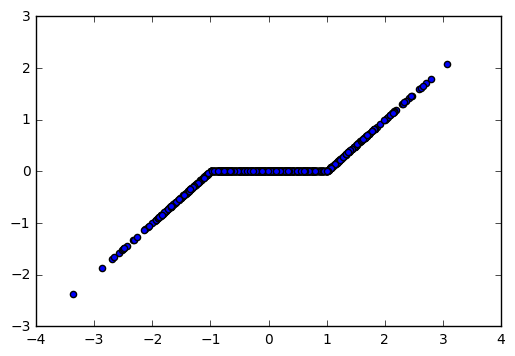

In [7]:
x = randn(1000)
x_bar = prox_lasso(x, 0.5, 2)
plt.scatter(x = x, y = x_bar)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

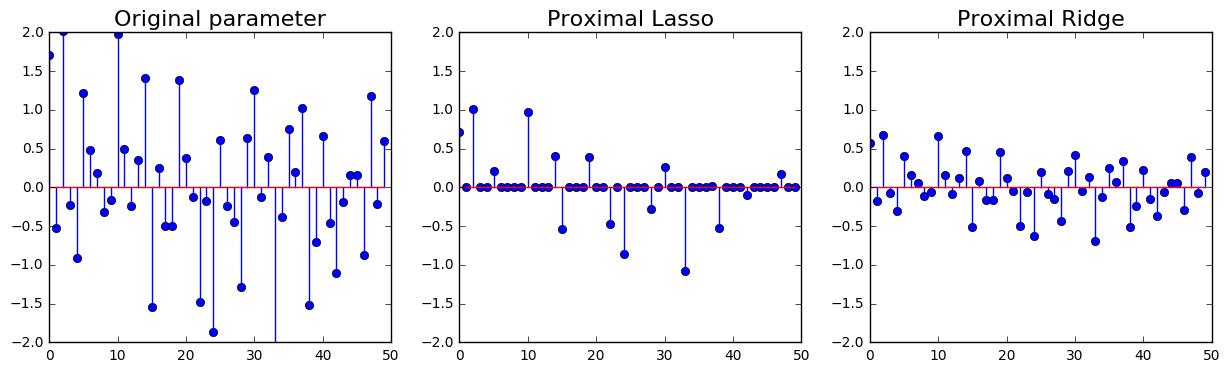

In [8]:
x = randn(50)
l_l1 = 1.
l_l2 = 2

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

## Question

- Comment what you observe (1 or 2 sentences).

For the lasso regularization, the proximal operator is of the form: $\text{sign}(x)(|x|-\lambda)_{+}$, which means that the coefficients between $-\lambda$ and $+\lambda$ are shrinked to zero, and the others are decreased by the constant scalar $\lambda$, which is what we observe here.

On the other hand, the proximal operator of the ridge penalization is of the form: $\frac{x}{1 + \lambda}$ ; the magnitude of each coefficient is therefore shrinked by the same factor $\frac{1}{1 + \lambda}$, but none of them is set to zero.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [9]:
def loss_linreg(x):
    """Least-squares loss"""
    n = n_samples
    result = (1/(2*n)) * (((b - np.dot(A, x)) ** 2).sum())
    return result

def grad_linreg(x):
    """Least-squares gradient"""
    n = n_samples
    result = (1/n)*np.dot(np.transpose(A), (np.dot(A, x) - b))
    return result

def loss_logreg(x):
    """Logistic loss"""
    n = n_samples
    result = (1/(2*n))*sum(np.log(1 + np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x))) for i in range(n))
    return result

def grad_logreg(x):
    """Logistic gradient"""
    n = n_samples
    result = (1/(2*n))*sum((-b[i]*np.transpose(A[i, :])*np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x)))/(1 + np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x))) for i in range(n))
    return result

In [10]:
from scipy.optimize import check_grad

In [11]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
x = coefs
print('Check the linreg gradient: ', check_grad(loss_linreg, grad_linreg, x))

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
x = coefs
print('Check the linlog gradient: ', check_grad(loss_logreg, grad_logreg, x))

Check the linreg gradient:  6.9221029851e-08
Check the linlog gradient:  1.92080335757e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [12]:
from numpy.linalg import norm

ISTA function, and Lipschitz constants for linear and logistic regression

In [13]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""  
    n = A[:, 1].size
    result = (1/n) * norm(np.dot(np.transpose(A), A), 2)
    return result
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    n = A[:, 1].size
    result = (1/(4*n)) * norm(np.dot(np.transpose(A), A), 2)
    return result

#In order to keep track of the computed x's, we add a list of them in the prototype below.

def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    
    #list of x
    list_x = [x0]
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
#     if verbose:
#         print("Lauching ISTA solver...")
#         print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x = prox_g(x - step*grad_f(x), s, step)
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        list_x.append(x)
#         if k % 10 == 0 and verbose:
#             print(' | '.join([("%d" % k).rjust(8), 
#                               ("%.2e" % obj).rjust(8), 
#                               ("%.2e" % err).rjust(8)]))
    return x, objectives, errors, list_x

FISTA function

In [14]:
#In order to keep track of the computed x's, we add a list of them in the prototype below. 

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()   
    
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # List of x
    list_x = [x0]
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    
    t = 1.
    t_new = 1.
    
#     if verbose:
#         print("Lauching FISTA solver...")
#         print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):        
        x_new = prox_g(z - step*grad_f(z), s, step)
        t_new = (1/2)*(1 + np.sqrt(1 + 4*(t**2)))
        z_new = x_new + ((t-1)/t_new)*(x_new - x)
        
        x = x_new
        t = t_new
        z = z_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        list_x.append(x)
#         if k % 10 == 0 and verbose:
#             print(' | '.join([("%d" % k).rjust(8), 
#                               ("%.2e" % obj).rjust(8), 
#                               ("%.2e" % err).rjust(8)]))
    return x, objectives, errors, list_x

We run a test below without any regularization to quickly compare the two algorithms:

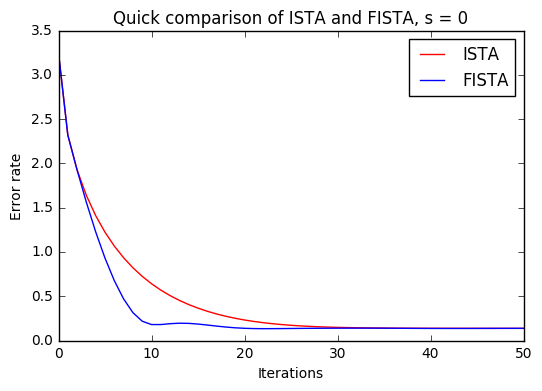

In [15]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Y = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)

plt.plot(Z[2],'r',label = "ISTA")
plt.plot(Y[2],'b',label = "FISTA")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.title("Quick comparison of ISTA and FISTA, s = 0")
plt.xlim(0,50)
plt.show()

## Algorithms comparison and numerical experiments

In [16]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In the following cell we compute a precise minimum and a precise minimizer of the linear regression with ridge regression problem with the FISTA algorithm and 1000 iterations.

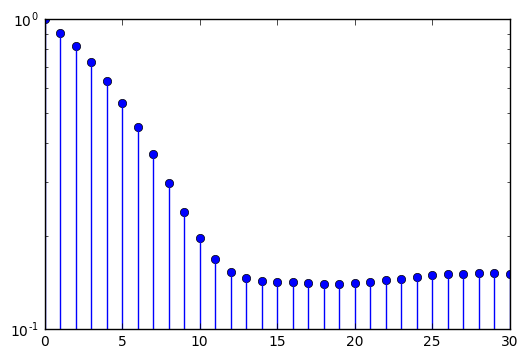

In [17]:
#Simulation of the features and the target for linear regression
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

#Run FISTA
Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.stem(Z[2])
ax.set_yscale('log')
plt.xlim(0, 30)
plt.show()

#Compute the minimizer and the minimum
minimizer = Z[0]
min_objective = Z[1][-1]

To get the minimizer and the minimum, we take the last x given by FISTA, which is the minimizer, and the last element of the list "objectives" given by FISTA.

### Compare the convergences of ISTA and FISTA

Let's focus first on the distance to the minimizer.

We first run the FISTA algorithm with 1000 iterations and take as minimizer the last x given by the algorithm. This will be our reference.

Then, we run ISTA and FISTA side by side, with 200 iterations. We use the distance of each x to the reference as a measure of the performance of the algorithm. The distance used is the quadratic norm.

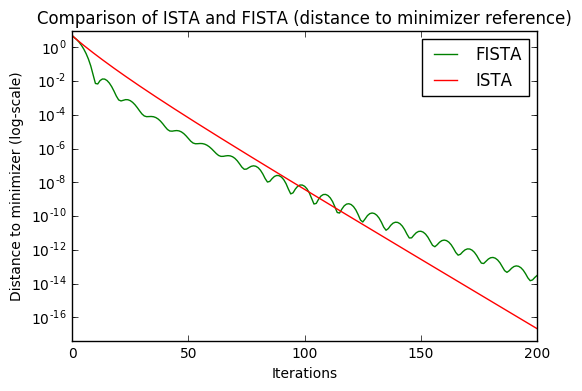

In [18]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

reference = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

distance_fista = Z[3] - reference[0]
distance_to_minimizer_fista = [ridge(x,2) for x in distance_fista]
distance_ista = Y[3] - reference[0]
distance_to_minimizer_ista = [ridge(x,2) for x in distance_ista]

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, distance_to_minimizer_fista, 'g', label = "FISTA")
plt.plot(x, distance_to_minimizer_ista, 'r', label = "ISTA")
ax.set_yscale('log')
plt.xlim(0, 200)
plt.ylim(np.exp(-40), 10)
plt.xlabel('Iterations')
plt.ylabel('Distance to minimizer (log-scale)')
plt.legend()
plt.title("Comparison of ISTA and FISTA (distance to minimizer reference)")
plt.show()

For information, we also compute the distance to the minimizer given by the last iteration of each algorithm.

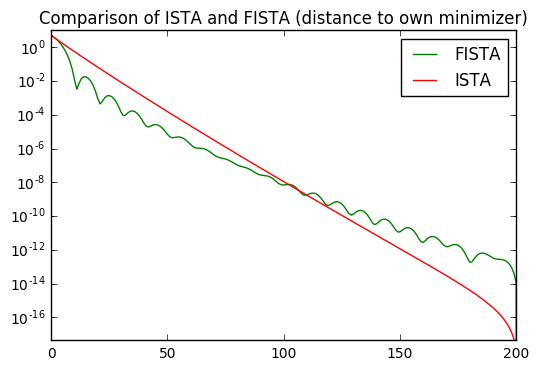

In [19]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

distance_fista = Z[3] - Z[0]
distance_to_minimizer_fista = [ridge(x,2) for x in distance_fista]
distance_ista = Y[3] - Y[0]
distance_to_minimizer_ista = [ridge(x,2) for x in distance_ista]

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, distance_to_minimizer_fista, 'g',label = "FISTA")
plt.plot(x, distance_to_minimizer_ista, 'r', label = "ISTA")
ax.set_yscale('log')
plt.legend()
plt.xlim(0, 200)
plt.title('Comparison of ISTA and FISTA (distance to own minimizer)')
plt.ylim(np.exp(-40), 10)
plt.show()

We observe by comparing the performance of the two algorithms on the logarithm scale, that FISTA converges faster than ISTA until an error of approximately $10^{-8}$. After $10^{-8}$, we saw before that the gradient becomes not accurate enough (see `check_grad`), and we cannot trust what happens after.

Now, let's focus on the distance to the minimum.

Like before, we do both approaches.

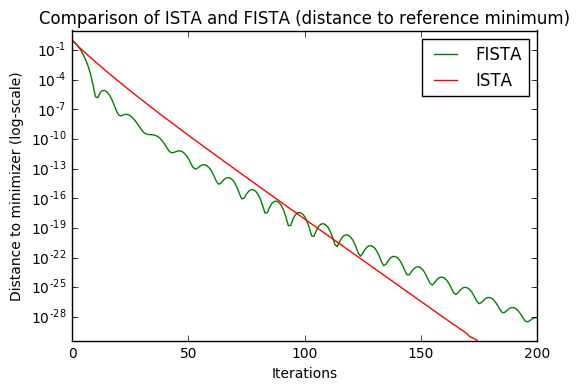

In [20]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

reference = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

distance_fista = Z[1] - reference[1][-1]
distance_to_minimizer_fista = [ridge(x,2) for x in distance_fista]
distance_ista = Y[1] - reference[1][-1]
distance_to_minimizer_ista = [ridge(x,2) for x in distance_ista]

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, distance_to_minimizer_fista, 'g',label = "FISTA")
plt.plot(x, distance_to_minimizer_ista, 'r', label = "ISTA")
ax.set_yscale('log')
plt.xlim(0, 200)
plt.ylim(np.exp(-70), 10)
plt.xlabel('Iterations')
plt.ylabel('Distance to minimizer (log-scale)')
plt.title("Comparison of ISTA and FISTA (distance to reference minimum)")
plt.legend()
plt.show()

For information, we show below the comparison of ISTA and FISTA with respect to their own minimum:

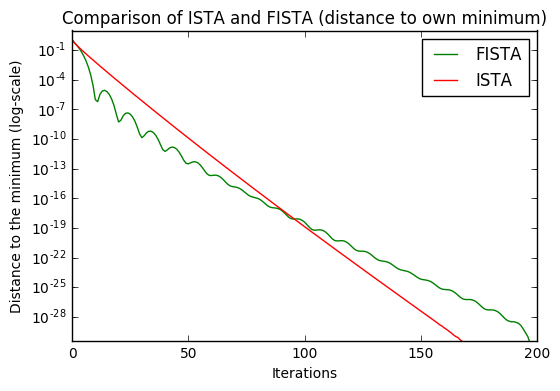

In [21]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

reference = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

distance_fista = Z[1] - Z[1][-1]
distance_to_minimizer_fista = [ridge(x,2) for x in distance_fista]
distance_ista = Y[1] - Y[1][-1]
distance_to_minimizer_ista = [ridge(x,2) for x in distance_ista]

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, distance_to_minimizer_fista, 'g',label = "FISTA")
plt.plot(x, distance_to_minimizer_ista, 'r',label = 'ISTA')
ax.set_yscale('log')
plt.xlim(0, 200)
plt.ylim(np.exp(-70), 10)
plt.xlabel('Iterations')
plt.ylabel('Distance to the minimum (log-scale)')
plt.title("Comparison of ISTA and FISTA (distance to own minimum)")
plt.legend()
plt.show()

We observe the same phenomena than for the minimizer: above a certain threshold, FISTA converges faster than ISTA. Below, what we measure is more uncertain.

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

# Influence of correlation

To study the influence of the correlation of the features on the performance of the two algorithms, we simulate three datasets with different correlations ('corr'): 0.2, 0.5 and 0.8. First, we study linear regression, and logistic regression with FISTA, and then we study linear and logistic with ISTA. The other parameters remain constant.

#### FISTA for linear regression

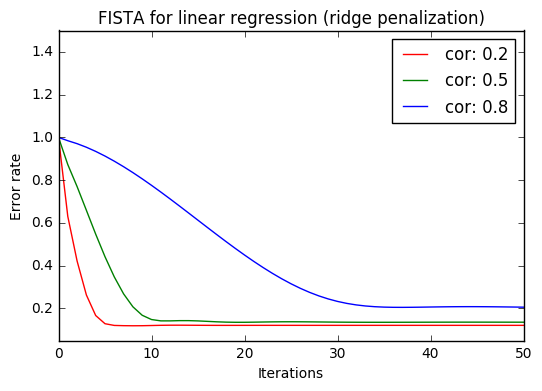

In [22]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.2)
L = lip_linreg(A)
X = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)
Y = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.8)
L = lip_linreg(A)
Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X[2], 'r', label = 'cor: 0.2')
plt.plot(x, Y[2], 'g', label = 'cor: 0.5')
plt.plot(x, Z[2], 'b', label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.5)
plt.title('FISTA for linear regression (ridge penalization)')
plt.legend()
plt.show()

#### FISTA for logistic regression

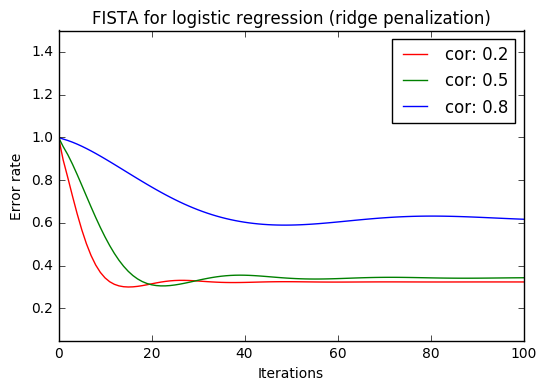

In [23]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.2)
L = lip_logreg(A)
X = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)
Y = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.8)
L = lip_logreg(A)
Z = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X[2], 'r', label = 'cor: 0.2')
plt.plot(x, Y[2], 'g', label = 'cor: 0.5')
plt.plot(x, Z[2], 'b', label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error rate')

plt.xlim(0, 100)
plt.ylim(0.05, 1.5)
plt.title('FISTA for logistic regression (ridge penalization)')
plt.legend()
plt.show()

#### ISTA for linear regression

/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in square
/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in square


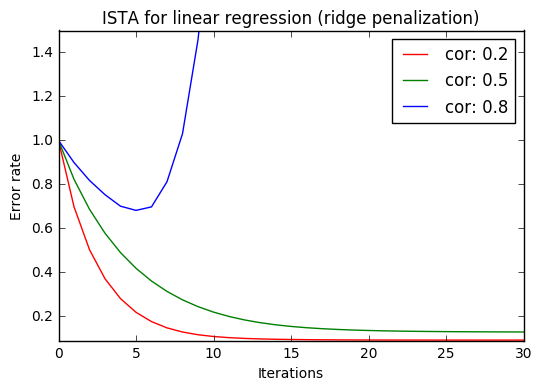

The three Lipschitz constants associated are: 1.82158831427 , 3.25954447596 , 5.47372427528


In [26]:
list_of_L = []
A, b = simu_linreg(coefs, n_samples=1000, corr=0.2)
list_of_L.append(lip_linreg(A))
X = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
list_of_L.append(lip_linreg(A))
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.7)
list_of_L.append(lip_linreg(A))
Z = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X[2], 'r', label = 'cor: 0.2')
plt.plot(x, Y[2], 'g', label = 'cor: 0.5')
plt.plot(x, Z[2], 'b', label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error rate')

plt.xlim(0, 30)
plt.ylim(0.09, 1.5)
plt.title('ISTA for linear regression (ridge penalization)')
plt.legend()
plt.show()

print('The three Lipschitz constants associated are:',list_of_L[0],',',list_of_L[1],',',list_of_L[2])

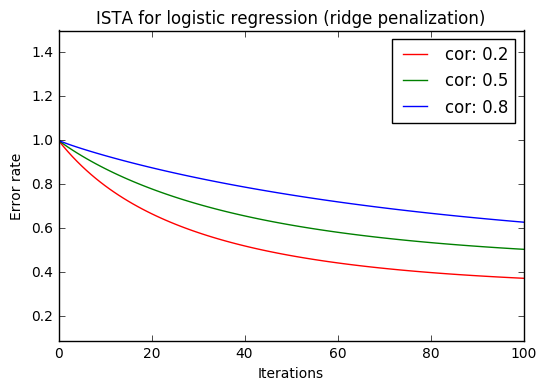

The three Lipschitz constants associated are: 0.443800237931 , 0.807658269239 , 2.23826640584


In [27]:
list_of_L = []
A, b = simu_logreg(coefs, n_samples=1000, corr=0.2)
list_of_L.append(lip_logreg(A))
X = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
list_of_L.append(lip_logreg(A))
Y = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.8)
list_of_L.append(lip_logreg(A))
Z = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X[2], 'r', label = 'cor: 0.2')
plt.plot(x, Y[2], 'g', label = 'cor: 0.5')
plt.plot(x, Z[2], 'b', label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error rate')

plt.xlim(0, 100)
plt.ylim(0.09, 1.5)
plt.title('ISTA for logistic regression (ridge penalization)')
plt.legend()
plt.show()

print('The three Lipschitz constants associated are:',list_of_L[0],',',list_of_L[1],',',list_of_L[2])

We observe that when the correlation is higher, the algorithms' convergence is slower. We also observe that the Lipschitz constant increases with the correlation. In the course, we showed with Beck Teboulle and Nesterov theorem that the error is upper-bounded linearly by $L$, this is why the error convergence can be slower with higher correlation.

Besides, when the correlation between the features grows, we have observed that the Lipschitz constant is higher. As a consequence, the steps are shorter in the update algorithm of ISTA and FISTA, hence the convergence is slower.

# Influence of level of ridge penalization

#### FISTA for different levels of ridge penalization (linear regression)

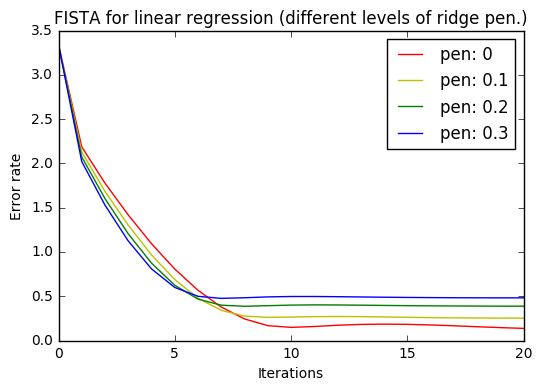

In [30]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Z1 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =50)
Z2 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =50)
Z3 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =50)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.title('FISTA for linear regression (different levels of ridge pen.)')
plt.xlabel('Iterations')
plt.ylabel('Error rate')

plt.xlim(0, 20)
plt.legend()
plt.show()

#### ISTA for different levels of ridge penalization (linear regression)

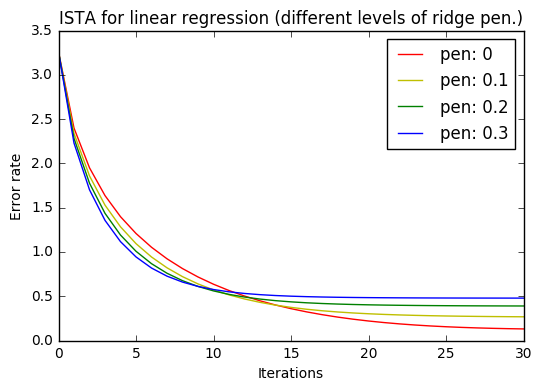

In [31]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Z1 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =50)
Z2 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =50)
Z3 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =50)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('ISTA for linear regression (different levels of ridge pen.)')

plt.xlim(0, 30)
plt.legend()
plt.show()

We observe that the convergence speed is greater when the penalization is increased. Nevertheless, the error rate converges to a higher value when the penalization is higher. This is due to the fact that, as we saw before, the penalization affects the magnitude of the coefficients ; therefore, the higher the penalization parameter, the lower the coefficients. As a consequence, the error rate associated to a higher penalization is higher. In any case, FISTA converges still faster than ISTA.

#### ISTA for different levels of ridge penalization (logistic regression)

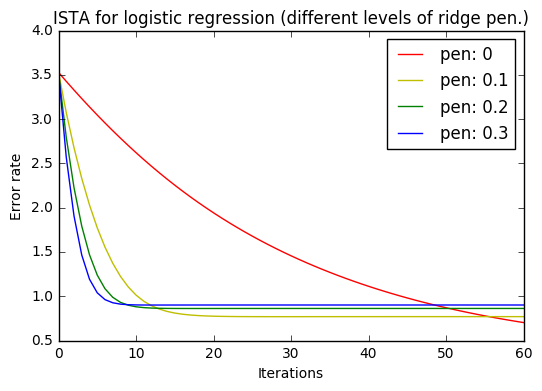

In [32]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =60)
Z1 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =60)
Z2 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =60)
Z3 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =60)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('ISTA for logistic regression (different levels of ridge pen.)')

plt.xlim(0, 60)
plt.legend()
plt.show()

#### FISTA for different levels of ridge penalization (logistic regression)

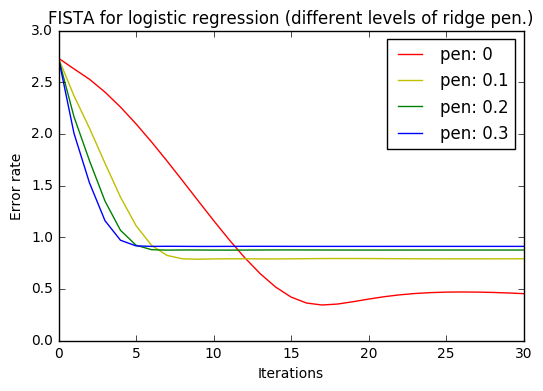

In [35]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Z1 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =50)
Z2 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =50)
Z3 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =50)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('FISTA for logistic regression (different levels of ridge pen.)')

plt.xlim(0, 30)
plt.legend()
plt.show()

We observe the same phenomena and apply the same explanations than before.

# Comparison of Ridge and Lasso for performance

#### Comparison for FISTA with linear regression

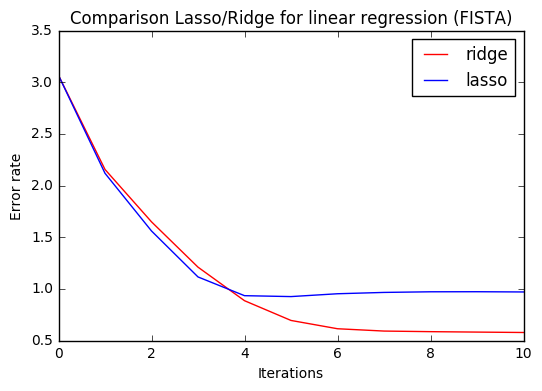

In [37]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50)
Z1 = fista(x, loss_linreg, grad_linreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =50)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('Comparison Lasso/Ridge for linear regression (FISTA)')

plt.xlim(0, 10)
plt.legend()
plt.show()

#### Comparison for FISTA with logistic regression

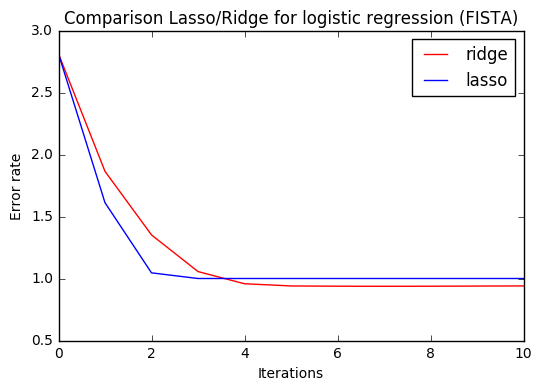

In [38]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50)
Z1 = fista(x, loss_logreg, grad_logreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =50)


x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('Comparison Lasso/Ridge for logistic regression (FISTA)')

plt.xlim(0, 10)
plt.legend()
plt.show()

#### Comparison for ISTA with linear regression

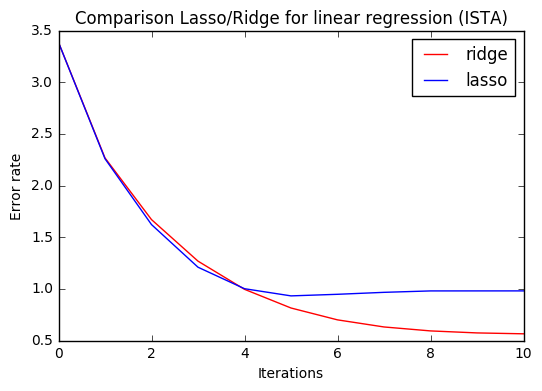

In [40]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50)
Z1 = ista(x, loss_linreg, grad_linreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =50)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('Comparison Lasso/Ridge for linear regression (ISTA)')

plt.xlim(0, 10)
plt.legend()
plt.show()

#### Comparison for ISTA with logistic regression

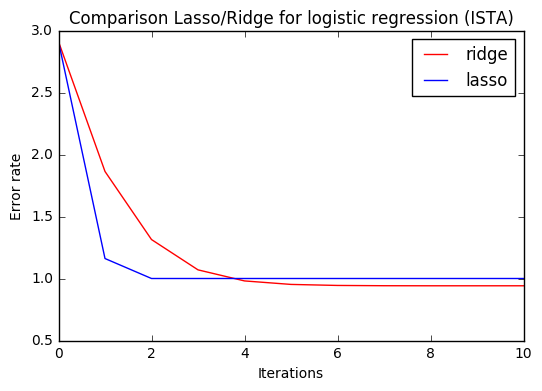

In [58]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50)
Z1 = ista(x, loss_logreg, grad_logreg, lasso, prox_lasso, 1/L, s=1, n_iter =50)


x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('Comparison Lasso/Ridge for logistic regression (ISTA)')

plt.xlim(0, 10)
plt.legend()
plt.show()

We observe that the convergece is always faster for Lasso penalization, assuming that we take the same penalization parameter. However, the error rate at the convergence is higher for lasso than for ridge penalization.

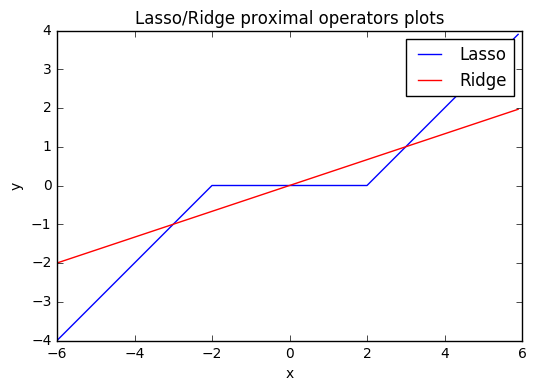

In [56]:
x = np.arange(-6,6,0.1)
plt.plot(x,prox_lasso(x,1,2),'b',label = "Lasso")
plt.plot(x,prox_ridge(x,1,2),'r',label = "Ridge")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Lasso/Ridge proximal operators plots")

We can explain the difference of convergence speeds as follows. We can see a plot of the two proximal operators above.

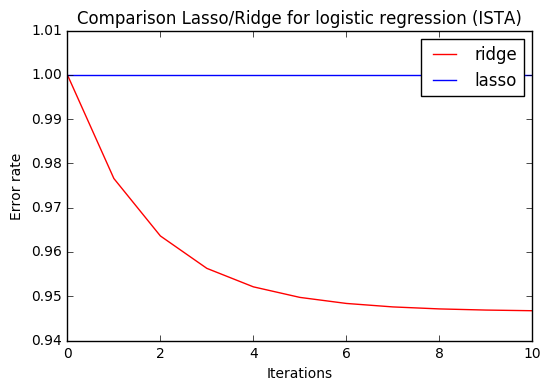

In [68]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = np.zeros(50)
Z0 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50)
Z1 = ista(x, loss_logreg, grad_logreg, lasso, prox_lasso, 1/L, s=1, n_iter =50)


x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('Comparison Lasso/Ridge for logistic regression (ISTA)')

plt.xlim(0, 10)
plt.legend()
plt.show()

When we choose as starting point a vector of zeros, the lasso does not converge at all because the sequence is stuck between the negative and positive threshold (as we can see on the plot above). On the contrary, when we choose a random vector as starting point, the algorithm converges, with a higher speed than for the ridge, because the slope of its proximal operator, outside the thresholds, is higher than the slope for ridge penalization ($1$ vs. $\frac{1}{1 + \lambda}$). But in the end, the lasso error rate is still higher than the ridge error rate, because a lot of coefficients are shrinked to zero.